<a href="https://colab.research.google.com/github/Srourrzan/AI_refresher/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import os;
import urllib.request;

def download_east_model():
  url = "https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb";
  model_path = "frozen_east_text_detection.pb";
  if not os.path.exists(model_path):
    print("Downloading EAST...");
    urllib.request.urlretrieve(url, model_path);
    print("model downloaded");
  else:
    print("model already exist");

download_east_model();

model already exist


In [94]:
!pip install easyocr

In [95]:
import easyocr;
import cv2;
import sys;
import numpy as np;
import matplotlib.pyplot as plt;

In [96]:

class OCR:
  def __init__(self,east_model_path: str ,languages: list = ['en']):
    self.__reader = easyocr.Reader(languages, gpu=False);
    if not cv2.os.path.exists(east_model_path):
      raise FileNotFoundError(f"EAST model not found at {east_model_path}");
    self.__net = cv2.dnn.readNet(east_model_path);
    return ;

  def preprocess_image(self, image_path: str) -> (np.ndarray, np.ndarray):
    image: np.ndarray = cv2.imread(image_path);
    if image is None:
      raise ValueError("Image not found at path.");
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY);
    return (image, gray_img);

  def extract_text(self, image_path: str) -> (np.ndarray, list):
    start_x: int;
    start_y: int;
    end_x: int;
    end_y: int;
    original_img: np.ndarray;
    structured_data: list = [];

    original_img, _ = self.preprocess_image(image_path);
    boxes: list = self.east_detection(original_img);
    for box in boxes:
      pad: int = 2;
      start_x, start_y, end_x, end_y = box;
      roi = original_img[max(0, start_x - pad):min(original_img.shape[0], end_y + pad),
                          max(0, start_x - pad):min(original_img.shape[1], end_x + pad)];
      if roi.size == 0:
        continue;
      results: list = self.__reader.readtext(roi);
      for (_, text, prob) in results:
        data: dict = {
            "text": text,
            "confidence": round(float(prob), 4),
            "bounding_box": [[start_x, start_y], [end_x, start_y], [end_x, end_y], [start_x, end_y]]
        };
        structured_data.append(data);
    return (original_img, structured_data);

  # EAST requires multiples of 32 for dimensions, resize to 320x320 for speed, or 640x640 for better accuracy
  # Conv_7/Sigmoid layer outputs the confidence scores for the detected text boxes
  # concat_3 layer outputs the geometry of the detected boxes
  # NMSBoxes Non-Maximum Suppresion is used to remove overlapping boxes
  def east_detection(self, image: np.ndarray, min_confidence: float = 0.5, resize: int = 320) -> list:
    new_width: int;
    new_height: int;
    original_width: int;
    original_height: int;
    scores: np.ndarray;
    geometry: np.ndarray;
    rects: list = [];
    confidence: list = [];
    final_boxes: list = [];
    layer_names: list = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"];

    original_height, original_width = image.shape[:2];
    new_height, new_width = (resize, resize);
    ratio_w: float = original_width / float(new_width);
    ratio_h: float = original_height / float(new_height);
    blob: np.ndarray = cv2.dnn.blobFromImage(image, 1.0, (new_width, new_height), (123.68, 116.78, 103.94), swapRB=True, crop=False);
    self.__net.setInput(blob);
    (scores, geometry) = self.__net.forward(layer_names);
    rects, confidence = self.__locate_detected_text(scores, geometry, min_confidence);
    indices: np.ndarray = cv2.dnn.NMSBoxes(rects, confidence, min_confidence, 0.4);
    if (len(indices) > 0):
      for i in indices.flatten():
        box: tuple = rects[i];
        final_boxes.append([
            int(box[0] * ratio_w), int(box[1] * ratio_h),
            int(box[2] * ratio_w), int(box[3] * ratio_h)
        ]);
    return (final_boxes);

  def __locate_detected_text(self, scores: np.ndarray, geometry: np.ndarray, min_confidence: float) -> (list, list):
    rows: int;
    cols: int;
    rects: list = [];
    confidence: list = [];

    rows, cols = scores.shape[2:4];
    for y in range(rows):
      scores_data: np.ndarray = scores[0, 0, y];
      x_data0: np.ndarray = geometry[0, 0, y];
      x_data1: np.ndarray = geometry[0, 1, y];
      x_data2: np.ndarray = geometry[0, 2, y];
      x_data3: np.ndarray = geometry[0, 3, y];
      angles_data: np.ndarray = geometry[0, 3, y];
      for x in range(cols):
        if (scores_data[x] < min_confidence):
          continue;
        offset_x: float = x * 4.0;
        offset_y: float = y * 4.0;
        angle: np.float32 = angles_data[x];
        cos: np.float32 = np.cos(angle);
        sin: np.float32 = np.sin(angle);
        h: np.float32 = x_data0[x] + x_data2[x];
        w: np.float32 = x_data1[x] + x_data3[x];
        end_x: int = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]));
        end_y: int = int(offset_y - (sin * x_data1[x]) + (cos * x_data2[x]));
        start_x: int = int(end_x - w);
        start_y: int = int(end_y - h);
        rects.append((start_x, start_y, end_x, end_y));
        confidence.append(scores_data[x]);
    return (rects, confidence);

  def visualize(self, image: np.ndarray, results: list):
    bbox: list;

    for res in results:
      bbox = res["bounding_box"];
      top_left: tuple = tuple(bbox[0]);
      bottom_right: tuple = tuple(bbox[2]);
      cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2);
      cv2.putText(image, res["text"], (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color=(50, 255, 0), thickness=2);
    plt.figure(figsize=(10, 10));
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
    plt.axis("off");
    plt.show();

{'text': 'This is a', 'confidence': 0.658, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'ocr code', 'confidence': 0.9786, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'of file for', 'confidence': 0.9801, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'The quic', 'confidence': 0.9566, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'lazy fox', 'confidence': 0.8778, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'over the', 'confidence': 0.9907, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'iumned', 'confidence': 0.8375, 'bounding_box': [[34, 282], [158, 282], [158, 313], [34, 313]]}
{'text': 'This', 'confidence': 0.9999, 'bounding_box': [[24, 94], [100, 94], [100, 120], [24, 120]]}
{'text': 'This', 'confidence': 0.9999, 'bounding_box': [[-16, 315], [100, 315], [100, 346], [-16, 346]]}
{'text': 'ocr', 'confidence': 0.7487, 'bound

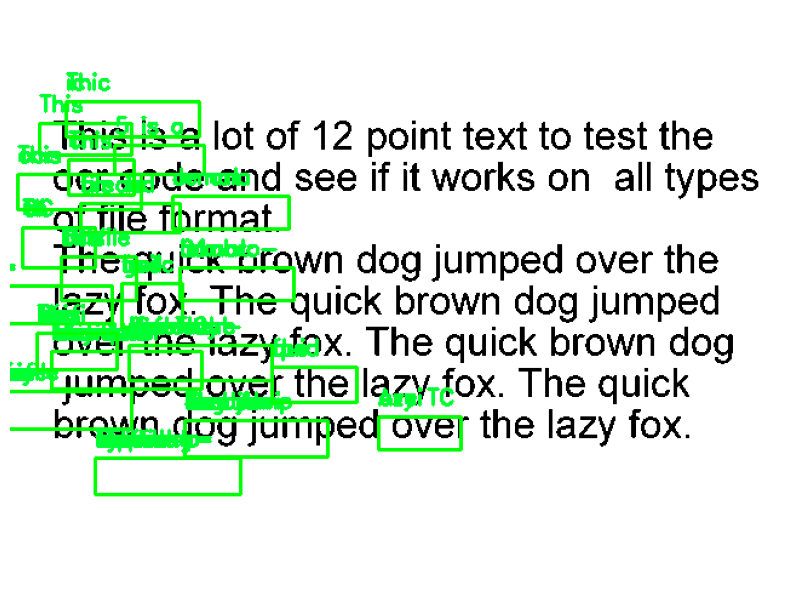

In [97]:
img_path: str = "test-image-for-recognition.png";
model_path = "/content/frozen_east_text_detection.pb";
ocr: OCR = OCR(model_path);
try:
  img, ocr_res = ocr.extract_text(img_path);
  for d in ocr_res:
    print(f"{d}");
  ocr.visualize(img, ocr_res);
except Exception as e:
  print(f"Error: {e}", file=sys.stderr);

##### Testing code (building locgic)

In [98]:
ocr: OCR = OCR(model_path);
img_path: str = "test-image-for-recognition.png";
image, gray = ocr.preprocess_image(img_path);
print(f"image {type(image)}");
print(f"gray {type(gray)}");
print(image.shape);
print(image.shape[:2]);

image <class 'numpy.ndarray'>
gray <class 'numpy.ndarray'>
(480, 640, 3)
(480, 640)


In [99]:
results:list = ocr.extract_text(img_path);
results

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [100]:
results[0][1], results[1][1], results[2][1], results[3][1]

IndexError: tuple index out of range

In [ ]:
type(results[0][0]), type(results[0][1]), type(results[0][2])

In [ ]:
results[0][0]

In [ ]:
[list(map(int, point)) for point in results[0][0]]

In [ ]:
[list(map(float, point)) for point in results[0][0]]

In [ ]:
[list(map(str, point)) for point in results[0][0]]

In [ ]:
ocr.__reader